# Intro

This notebook can be used to simulate the route of an UAV using the Markov chain method. The user can input a list of regions and specify the starting and ending region. The simulator will then generate a probability matrix that describes the probability of the UAV selecting the next region based on its current region. Using this probability matrix, the simulator will calculate possible routes from the starting point to the ending point using the Markov chain method.

# Import Libraries

In [1]:
from IPython.display import Image as ImageDisplay

from markovchain import MarkovChain

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Listing regions

Specify the regions in `region_list` which will be used in the simulation.

Regardding `remove_self_flight` variable:

- If set to `True`, the simulator WILL REMOVE self-flights from the generated probability matrix.
- If set to `False`, the simulator will not remove self-flights from the generated probability matrix.

This code below will generate a probability matrix that describes the probability of the UAV selecting the next region based on its current region.



In [2]:
mc = MarkovChain(region_list=['Seongsu', 'Onsu', 'Yaksu', 'Isu'],
                 remove_self_flight=True)

base_img = mc.plot_base()


# Determine the starting and ending region.

Specify the starting region in `start` and ending region in `end`.

This code below will generate a new probability matrix that block 
direct flight from starting region to ending region.

It will also plot the graph node that represent the probability matrix.


 BLOCKED MATRIX BETWEEN Seongsu AND Onsu
         Seongsu  Onsu  Yaksu   Isu
Seongsu     0.00  0.00   0.18  0.82
Onsu        0.00  0.00   0.70  0.30
Yaksu       0.61  0.27   0.00  0.12
Isu         0.26  0.13   0.61  0.00


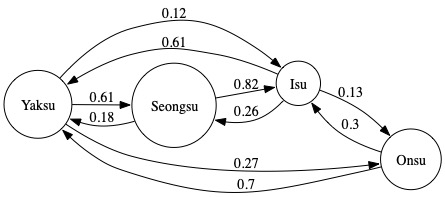

In [3]:
start = 'Seongsu'
end = 'Onsu'
blocked_img = mc.plot_blocked_node(node_1=start,
                                   node_2=end)
ImageDisplay(blocked_img)

# Simulate

This code below will generate possible route from
the starting region into the ending region.

This code also generate several jpeg files and a gif
file that represent the simulation process.

Step: 14
Route:  ['Seongsu', 'Isu', 'Yaksu', 'Isu', 'Yaksu', 'Seongsu', 'Isu', 'Seongsu', 'Isu', 'Seongsu', 'Isu', 'Yaksu', 'Isu', 'Yaksu', 'Onsu']


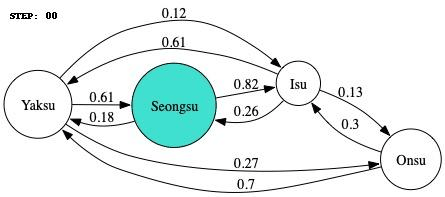

In [4]:
init_region = start
dest_region = end
plot_mode = 'blocked'
travel_simulated = mc.travel_simulation(init_region,
                                        dest_region,
                                        plot_mode
                                        )
print(f'Step: {len(travel_simulated)-1}')
print('Route: ',travel_simulated)

travel_img = mc.plot_travel_simulation(plot_mode)
ImageDisplay(travel_img)

# Calculate Probability ending in a region in n-step

This code below will present a graph of probability of ending in a region in n-step.

Seongsu Onsu


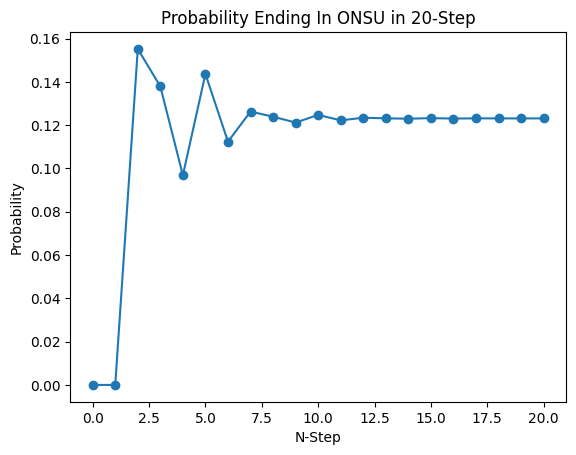

[0.0, 0.0, 0.1552, 0.137862, 0.09687584, 0.143643214, 0.11236048234399999, 0.12626198135992, 0.12389522968655678, 0.12118582791593345, 0.12471887307206334, 0.12221522057025204, 0.12340397559156831, 0.1231393748107539, 0.12296908873819623, 0.12323318659542308, 0.12303433433515822, 0.12313474441437257, 0.12310781330350534, 0.12309795127549938, 0.1231174588744744]


<Figure size 640x480 with 0 Axes>

In [5]:
init_region= start
final_region= end
matrix_df= mc.blocked_df

print(start, end)

n_step=20
res = mc.plot_prob_ending(init_region,
                    final_region,
                    matrix_df,
                    n_step)